In [1]:
import pandas as pd
import h2o
from h2o.automl import H2OAutoML
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Import label encoder
from sklearn import preprocessing

# Import a train/test set into H2O
from azureml.core import Workspace, Datastore, Dataset

In [2]:
h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=12  # in gigabytes
)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 0 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,18 days
H2O_cluster_name:,H2O_from_python_azureuser_1ivtkp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,11.69 Gb
H2O_cluster_total_cores:,6
H2O_cluster_allowed_cores:,6
H2O_cluster_status:,"locked, healthy"


In [3]:
datastore_name = 'workspaceblobstore'
# get existing workspace
workspace = Workspace.from_config()    
# retrieve an existing datastore in the workspace by name
datastore = Datastore.get(workspace, datastore_name)
# create a TabularDataset from 3 file paths in datastore
datastore_paths = [(datastore, 'UI/10-22-2021_045506_UTC/test.csv')]
test = Dataset.Tabular.from_delimited_files(path=datastore_paths)
test = test.to_pandas_dataframe()

In [4]:
test.head(5)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1
3,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2
4,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3


In [5]:
# Import a train/test set into H2O
from azureml.core import Workspace, Datastore, Dataset

datastore_name = 'workspaceblobstore'
# get existing workspace
workspace = Workspace.from_config()    
# retrieve an existing datastore in the workspace by name
datastore = Datastore.get(workspace, datastore_name)
# create a TabularDataset from 3 file paths in datastore
datastore_paths = [(datastore, 'UI/10-22-2021_045409_UTC/train.csv')]
train = Dataset.Tabular.from_delimited_files(path=datastore_paths)
train = train.to_pandas_dataframe()

In [6]:
train.head(5)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829



Skewness for Item_MRP :  0.055660346208835844

Skewness for Item_W :  -0.17953093828329283


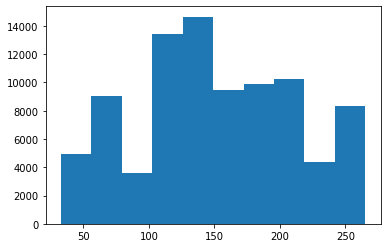

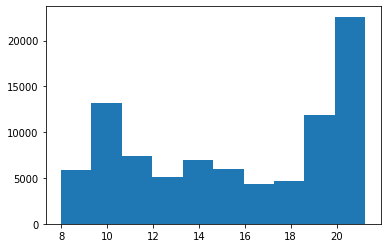

In [7]:
#Drop the ID columns

#train_as_df=train_as_df.drop(['Item_ID','Outlet_ID'], axis = 1)
#test_as_df=test_as_df.drop(['Item_ID','Outlet_ID'], axis = 1)

# Dropping the outlet id column
#train_as_df=train_as_df.drop(['Item_ID'], axis = 1)
#test_as_df=test_as_df.drop(['Item_ID'], axis = 1)

from scipy.stats import skew
from matplotlib import pyplot
from scipy.stats import boxcox
from numpy import exp

data = train['Item_MRP']
print( '\nSkewness for Item_MRP : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()

data = train['Item_W']
print( '\nSkewness for Item_W : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()

In [8]:
# Filter out -ve Sales values

cols = 'Sales'
negative_sales = train[train[cols] < 0]
negative_sales
#train = train[train[cols] >= 0] 
train['Sales'] = train['Sales'].abs()


Skewness for Sales :  1.1313029228390312


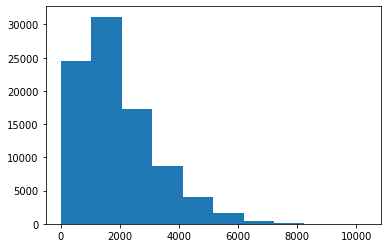

Text(0.5, 0, 'Sample')

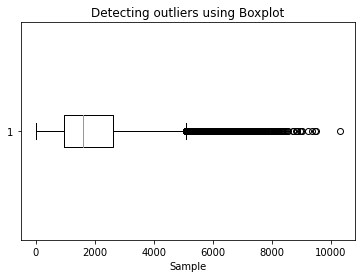

In [9]:
# Outlier Detection in 'Sales'
# After handling outliers in Sales, check the skewness and normality again - it should improve

data = train['Sales']
print( '\nSkewness for Sales : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()

plt.boxplot(data, vert=False)
plt.title("Detecting outliers using Boxplot")
plt.xlabel('Sample')

In [10]:
# Find the outlier datapoints in 'Sales'

# finding the 1st quartile
q1 = np.quantile(train['Sales'], 0.25)
 
# finding the 3rd quartile
q3 = np.quantile(train['Sales'], 0.75)
med = np.median(train['Sales'])
 
# finding the iqr region
iqr = q3-q1

print('Median', med)

# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

outliers = train[(train['Sales'] <= lower_bound) | (train['Sales'] >= upper_bound)].Sales
print('The following are the outliers in the boxplot:{}'.format(outliers))

Median 1606.3078770000002
1648.698681575 5081.1057586125 -1513.6889676875
The following are the outliers in the boxplot:13       6379.790499
30       6741.017116
33       6198.371937
228      5794.834611
246      8699.342857
            ...     
87746    5145.665334
87752    5392.408338
87762    6243.916532
87791    5896.324800
87833    6079.419800
Name: Sales, Length: 2378, dtype: float64


In [11]:
# Handle outliers by replacing values above/below a certain threhold with the threshold
# Winsorization: Percentile based flooring and capping
removeOutlier = '0' # 0 means don't exclude outliers

df=train
col='Sales'
for col in df:
    #get dtype for column
    dt = df[col].dtype 
    #check if we want to handle outliers?
    if removeOutlier == '1':
        #check if it is a numbers
        if dt == 'int64' or dt == 'float64':
            df[col]=df[col].clip(upper = (df[col].quantile(0.99))) 
            df[col]=df[col].clip(lower = (df[col].quantile(0.01)))

In [12]:
# Create a new field Item_Group based on Item_Type

# create a list of our conditions
conditions = [
    (train['Item_Type'] == 'Hard Drinks') | (train['Item_Type'] == 'Soft Drinks'),
    (train['Item_Type'] == 'Others') | (train['Item_Type'] == 'Household') | (train['Item_Type'] == 'Health and Hygiene'),
    (train['Item_Type'] == 'Baking Goods') | (train['Item_Type'] == 'Meat') | (train['Item_Type'] == 'Starchy Foods') | (train['Item_Type'] == 'Breads') | (train['Item_Type'] == 'Seafood'),
    (train['Item_Type'] == 'Fruits and Vegetables') | (train['Item_Type'] == 'Breakfast') | (train['Item_Type'] == 'Snack Foods') | (train['Item_Type'] == 'Frozen Foods') | (train['Item_Type'] == 'Canned') | (train['Item_Type'] == 'Dairy')
    ]

# create a list of the values we want to assign for each condition
values = ['Drinks', 'Non_Consummables', 'Food', 'Food']

# create a list of our conditions
conditions_t = [
    (test['Item_Type'] == 'Hard Drinks') | (test['Item_Type'] == 'Soft Drinks'),
    (test['Item_Type'] == 'Others') | (test['Item_Type'] == 'Household') | (test['Item_Type'] == 'Health and Hygiene'),
    (test['Item_Type'] == 'Baking Goods') | (test['Item_Type'] == 'Meat') | (test['Item_Type'] == 'Starchy Foods') | (test['Item_Type'] == 'Breads') | (test['Item_Type'] == 'Seafood'),
    (test['Item_Type'] == 'Fruits and Vegetables') | (test['Item_Type'] == 'Breakfast') | (test['Item_Type'] == 'Snack Foods') | (test['Item_Type'] == 'Frozen Foods') | (test['Item_Type'] == 'Canned') | (test['Item_Type'] == 'Dairy')
    ]

# create a list of the values we want to assign for each condition
values_t = ['Drinks', 'Non_Consummables', 'Food', 'Food']

In [13]:
train['Item_Group'] = np.select(conditions, values)
test['Item_Group'] = np.select(conditions_t, values_t)

In [14]:
#Derive the outlet age column

train['Outlet_Age'] = 2021 - train['Outlet_Year']
train=train.drop(['Outlet_Year'], axis = 1)

test['Outlet_Age'] = 2021 - test['Outlet_Year']
test=test.drop(['Outlet_Year'], axis = 1)

In [15]:
#Check for any missing values - train

round((train.isnull().sum() * 100/ len(train)),2).sort_values(ascending=False)

Item_ID                 0.0
Item_W                  0.0
Item_Type               0.0
Item_MRP                0.0
Outlet_ID               0.0
Outlet_Size             0.0
Outlet_Location_Type    0.0
Sales                   0.0
Item_Group              0.0
Outlet_Age              0.0
dtype: float64

In [16]:
#Check for any missing values - test

round((test.isnull().sum() * 100/ len(test)),2).sort_values(ascending=False)

Item_ID                 0.0
Item_W                  0.0
Item_Type               0.0
Item_MRP                0.0
Outlet_ID               0.0
Outlet_Size             0.0
Outlet_Location_Type    0.0
Item_Group              0.0
Outlet_Age              0.0
dtype: float64

In [17]:
# Break the item id into 2 columns item code and item number

#train['Item_Code'] = [x[:3] for x in train['Item_ID']]
#train['Item_Number'] = train['Item_ID'].str[-2:]
#train = train.drop(['Item_ID'], axis = 1)

#test['Item_Code'] = [x[:3] for x in test['Item_ID']]
#test['Item_Number'] = test['Item_ID'].str[-2:]
#test = test.drop(['Item_ID'], axis = 1)
#
#Convert Item_Number to character and sppend a prefix
#train['Item_Number'] = '__' + train['Item_Number'].astype(str)
#test['Item_Number'] = '__' + test['Item_Number'].astype(str)

In [18]:
train.head(5)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Size,Outlet_Location_Type,Sales,Item_Group,Outlet_Age
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,Small,Tier 2,2689.457781,Food,17
1,NCT54,21.102371,Meat,148.250214,OUT035,Small,Tier 1,3437.350375,Food,34
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,Small,Tier 3,3129.967268,Drinks,22
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,Small,Tier 1,1306.514376,Food,25
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,Small,Tier 3,1739.769829,Food,33


In [19]:
test.head(5)

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Size,Outlet_Location_Type,Item_Group,Outlet_Age
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,High,Tier 3,Food,22
1,FDG47,10.434425,Household,263.600449,OUT018,High,Tier 3,Non_Consummables,34
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,High,Tier 1,Non_Consummables,24
3,FDZ23,14.948546,Dairy,136.200508,OUT046,Medium,Tier 2,Food,17
4,FDC16,11.080042,Canned,173.145664,OUT018,Medium,Tier 3,Food,12


In [20]:
# One HOT Encoding

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    original_dataframe = pd.concat([original_dataframe, dummies], axis=1)
    original_dataframe=original_dataframe.drop([feature_to_encode], axis = 1)
    return(original_dataframe)

In [21]:
# Label Encoding

def label_encode(original_dataframe, feature_to_encode):
    # label_encoder object knows how to understand word labels.
    label_encoder = preprocessing.LabelEncoder()    
    # Encode labels in column 'species'.
    original_dataframe[feature_to_encode]= label_encoder.fit_transform(original_dataframe[feature_to_encode])  
    return(original_dataframe)

In [22]:
train = encode_and_bind(train, 'Item_Type')
train = label_encode(train, 'Outlet_Size')
train = label_encode(train, 'Outlet_Location_Type')
train = encode_and_bind(train, 'Outlet_ID')
#train = encode_and_bind(train, 'Item_Code')
#train = encode_and_bind(train, 'Item_Number')
train = encode_and_bind(train, 'Item_Group')
train = encode_and_bind(train, 'Item_ID')

In [23]:
test = encode_and_bind(test, 'Item_Type')
test = label_encode(test, 'Outlet_Size')
test = label_encode(test, 'Outlet_Location_Type')
test = encode_and_bind(test, 'Outlet_ID')
#test = encode_and_bind(test, 'Item_Code')
#test = encode_and_bind(test, 'Item_Number')
test = encode_and_bind(test, 'Item_Group')
test = encode_and_bind(test, 'Item_ID')

In [24]:
train.head(5)

,Item_W,Item_MRP,Outlet_Size,Outlet_Location_Type,Sales,Outlet_Age,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_ID_NCY30,Item_ID_NCY42,Item_ID_NCY53,Item_ID_NCZ17,Item_ID_NCZ18,Item_ID_NCZ29,Item_ID_NCZ41,Item_ID_NCZ42,Item_ID_NCZ53,Item_ID_NCZ54
0,21.027499,197.352319,2,1,2689.457781,17,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21.102371,148.250214,2,0,3437.350375,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20.882263,205.465010,2,2,3129.967268,22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21.050435,253.417583,2,0,1306.514376,25,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21.247876,240.871039,2,2,1739.769829,33,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
test.head(5)

,Item_W,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Age,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Item_ID_NCY30,Item_ID_NCY42,Item_ID_NCY53,Item_ID_NCZ17,Item_ID_NCZ18,Item_ID_NCZ29,Item_ID_NCZ41,Item_ID_NCZ42,Item_ID_NCZ53,Item_ID_NCZ54
0,10.156725,119.319482,0,2,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.434425,263.600449,0,2,34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.953589,246.286990,0,0,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14.948546,136.200508,1,1,17,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,11.080042,173.145664,1,2,12,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#corrMatrix = train.corr()
#print (corrMatrix)

In [27]:
#Convert pandas dataframe back to H2O frame
train = h2o.H2OFrame(train)
test = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [28]:
# Identify predictors and response
x = train.columns
y = "Sales"
x.remove(y)

In [29]:
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)

aml = H2OAutoML(max_models=25, seed=1)
aml.train(x=x, y=y, training_frame=train) 

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_7_AutoML_3_20211025_195812

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 1561801.840378596
RMSE: 1249.7207049491483
MAE: 983.1213044389818
RMSLE: 0.8446209808830579
R^2: 0.062473335543939634
Mean Residual Deviance: 1561801.840378596
Null degrees of freedom: 9936
Residual degrees of freedom: 9912
Null deviance: 16554290213.329544
Residual deviance: 15519624887.842108
AIC: 169967.0266981814

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 1621612.6535646736
RMSE: 1273.4255587056016
MAE: 999.3699942372264
RMSLE: 0.8504421910391257
R^2: 0.025657797011467087
Mean Residual Deviance: 1621612.6535646736
Null degrees of freedom: 87863
Residual degrees of freedom: 87836
Null deviance: 146236730327

In [30]:
# View the AutoML Leaderboard

lb = aml.leaderboard
#lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)
lb.head(rows=10) 

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_7_AutoML_3_20211025_195812,1.62161e+06,1273.43,1.62161e+06,999.37,0.850442
StackedEnsemble_AllModels_4_AutoML_3_20211025_195812,1.622e+06,1273.58,1.622e+06,999.526,0.84964
StackedEnsemble_AllModels_3_AutoML_3_20211025_195812,1.62203e+06,1273.59,1.62203e+06,999.541,0.849656
StackedEnsemble_AllModels_2_AutoML_3_20211025_195812,1.62339e+06,1274.12,1.62339e+06,999.761,0.850139
StackedEnsemble_AllModels_1_AutoML_3_20211025_195812,1.62346e+06,1274.15,1.62346e+06,999.765,0.850294
StackedEnsemble_BestOfFamily_4_AutoML_3_20211025_195812,1.62446e+06,1274.54,1.62446e+06,1000.37,0.850395
StackedEnsemble_BestOfFamily_7_AutoML_3_20211025_195812,1.62446e+06,1274.54,1.62446e+06,1000.3,0.851313
StackedEnsemble_AllModels_6_AutoML_3_20211025_195812,1.62466e+06,1274.62,1.62466e+06,1000.49,0.850361
XGBoost_grid_1_AutoML_3_20211025_195812_model_29,1.62535e+06,1274.89,1.62535e+06,1000.56,0.851462
StackedEnsemble_BestOfFamily_3_AutoML_3_20211025_195812,1.62539e+06,1274.91,1.62539e+06,1000.53,0.850703


In [31]:
# The leader model is stored here

aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_7_AutoML_3_20211025_195812

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 1561801.840378596
RMSE: 1249.7207049491483
MAE: 983.1213044389818
RMSLE: 0.8446209808830579
R^2: 0.062473335543939634
Mean Residual Deviance: 1561801.840378596
Null degrees of freedom: 9936
Residual degrees of freedom: 9912
Null deviance: 16554290213.329544
Residual deviance: 15519624887.842108
AIC: 169967.0266981814

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 1621612.6535646736
RMSE: 1273.4255587056016
MAE: 999.3699942372264
RMSLE: 0.8504421910391257
R^2: 0.025657797011467087
Mean Residual Deviance: 1621612.6535646736
Null degrees of freedom: 87863
Residual degrees of freedom: 87836
Null deviance: 146236730327.22778
Residual deviance: 142481374192.8065
AIC: 1505766.5634506945


In [32]:
# To generate predictions on a test set, you can make predictions
# directly on the `"H2OAutoML"` object or on the leader model
# object directly
#preds = aml.predict(test)
# or
preds = aml.leader.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset is missing column 'Item_ID_DRF60': substituting in a column of NaN
  warnings.warn(w)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset is missing column 'Item_ID_FDD39': substituting in a column of NaN
  warnings.warn(w)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset is missing column 'Item_ID_FDI12': substituting in a column of NaN
  warnings.warn(w)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset is missing column 'Item_ID_FDM57': substituting in a column of NaN
  warnings.warn(w)


In [33]:
preds.head(5)

predict
2102.36
1853.73
1889.76
1729.35
1510.65


In [34]:
df = test.cbind(preds)
df.head(5)
# Slice cols by vector of names
res = df[:, ["predict"]]
res.head(5)
#Rename column
res.set_names(['Sales']) 

Sales
2102.36
1853.73
1889.76
1729.35
1510.65
1988.92
1978.59
2150.99
1762.78
2059.92


In [35]:
# Export the file
# There are two ways to save the leader model -- binary format and MOJO format. If you're taking your leader model to production, 
# then we'd suggest the MOJO format since it's optimized for production use.

#h2o.export_file(res, path = "C:\\Data_Science\\Competitions\\MachineHack-2021\\my_submission.csv", force = True)

# Convert to Pandas dataframe
# Save as .CSV file
#res_as_df = h2o.as_list(res, use_pandas=True)
#res_as_df.to_csv('data/my_submission.csv', index=False)


In [36]:
from azureml.core import Workspace
from azureml.data import OutputFileDatasetConfig

ws = Workspace.from_config()

def_blob_store = ws.get_default_datastore()
output = OutputFileDatasetConfig(destination=(def_blob_store, 'sample/outputdataset'))

res_as_df = h2o.as_list(res, use_pandas=True)
res_as_df.to_csv('my_submission.csv', index=False)

In [37]:
h2o.save_model(aml.leader, path = "h20_model_bin")

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-ml2021/code/Users/SESA475934/h20_model_bin/StackedEnsemble_AllModels_7_AutoML_3_20211025_195812'

In [38]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/h2o/estimators/stackedensemble.py:925: H2ODeprecationWarning: The usage of stacked_ensemble.metalearner()['name'] will be deprecated. Metalearner now returns the metalearner object. If you need to get the 'name' please use stacked_ensemble.metalearner().model_id
  warnings.warn(


In [39]:
metalearner.coef_norm()

{'Intercept': 1912.716340931312,
 'XGBoost_grid_1_AutoML_3_20211025_195812_model_29': 11.241531657906092,
 'XGBoost_grid_1_AutoML_3_20211025_195812_model_30': 30.68805015437352,
 'XGBoost_grid_1_AutoML_3_20211025_195812_model_16': 5.182177130826238,
 'XGBoost_grid_1_AutoML_3_20211025_195812_model_23': 4.63661360752079,
 'GBM_2_AutoML_3_20211025_195812': 0.0,
 'GBM_1_AutoML_3_20211025_195812': 34.972224503250295,
 'XGBoost_grid_1_AutoML_3_20211025_195812_model_20': 34.36629343969541,
 'GBM_grid_1_AutoML_3_20211025_195812_model_12': 5.498026387680579,
 'GBM_grid_1_AutoML_3_20211025_195812_model_2': 4.452969818732136,
 'GBM_grid_1_AutoML_3_20211025_195812_model_6': 0.0,
 'GBM_3_AutoML_3_20211025_195812': 0.0,
 'GBM_grid_1_AutoML_3_20211025_195812_model_3': 0.0,
 'GBM_5_AutoML_3_20211025_195812': 6.811710346053932,
 'GBM_4_AutoML_3_20211025_195812': 0.0,
 'GBM_grid_1_AutoML_3_20211025_195812_model_9': 0.0,
 'XGBoost_grid_1_AutoML_3_20211025_195812_model_25': 1.4019256832760867,
 'GBM_grid_

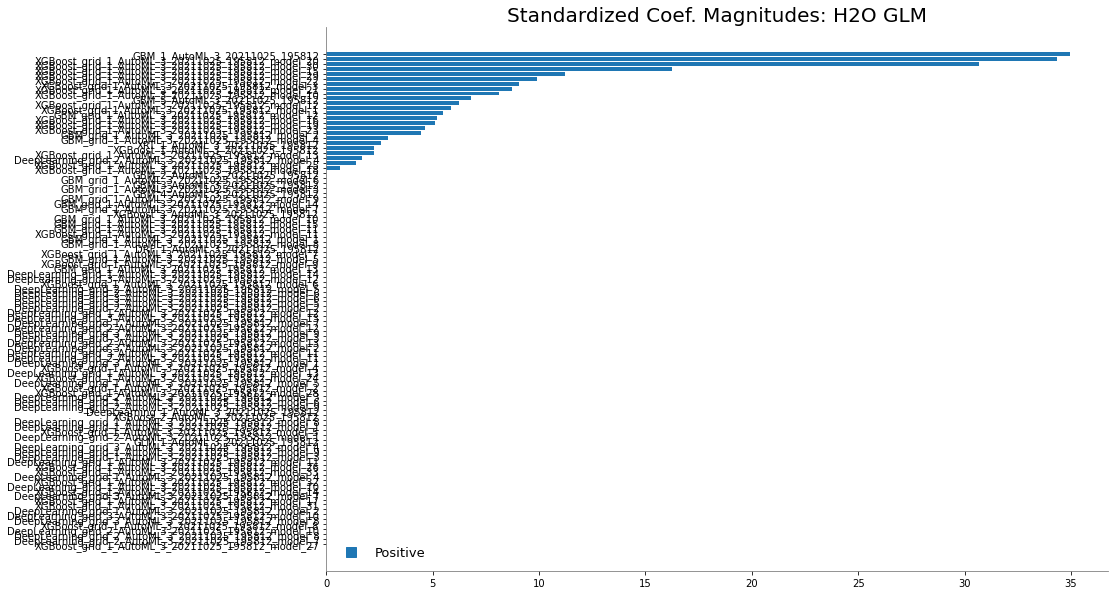

In [40]:
#We can also plot the base learner contributions to the ensemble.
%matplotlib inline
metalearner.std_coef_plot()